<a href="https://colab.research.google.com/github/Tanishtha-Reddy/IMFDB-Face-Recognition-Using-Deep-Learning/blob/main/Face_Recognition_Using_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMFDB FACE RECOGNITION USING DEEP LEARNING (PYTHON)

In [27]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means, _class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

plt.ion()
%matplotlib inline


In [29]:
opt = {
    'image_size': 32,
    'is_grayscale': True,
    'val_split': 0.75
}

In [30]:
imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

In [31]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'], opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []

    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")


    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y]
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list


def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)

        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray')
        else:
            plt.imshow(img)

        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [32]:
dirpath = '/content/drive/MyDrive/IMFDB'

X, y = load_data(dirpath)
N, H, W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

print(f"\n Dataset loaded successfully!")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"N (num images): {N}")
print(f"H (height): {H}")
print(f"W (width): {W}")
print(f"C (channels): {C}")

Dataset shape: (400, 32, 32)

 Dataset loaded successfully!
X shape: (400, 32, 32)
y shape: (400,)
N (num images): 400
H (height): 32
W (width): 32
C (channels): 1


In [33]:
print(f"\nNumber of unique classes: {len(np.unique(y))}")
print(f"Classes found: {np.unique(y)}")

# Count per class
print(f"\nImages per class:")
for class_id in np.unique(y):
    count = np.sum(y == class_id)
    # Find class name
    for name, id_val in imfdb_dict.items():
        if id_val == class_id:
            print(f"  {name}: {count} images")
            break


Number of unique classes: 8
Classes found: [0 1 2 3 4 5 6 7]

Images per class:
  MadhuriDixit: 50 images
  Kajol: 50 images
  SharukhKhan: 50 images
  ShilpaShetty: 50 images
  AmitabhBachan: 50 images
  KatrinaKaif: 50 images
  AkshayKumar: 50 images
  Amir: 50 images


IMPLEMENTING RESNET-50 ARCHITECTURE FROM SCRATCH

In [34]:
import torch
import torch.nn as nn
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.9.0+cpu


In [35]:
class BottleneckBlock(nn.Module):


    expansion = 4  # Output channels = channels * 4

    def __init__(self, in_channels, channels, stride=1):
        super(BottleneckBlock, self).__init__()

        out_channels = channels * self.expansion


        self.conv1 = nn.Conv2d(in_channels, channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)

        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=stride,
                              padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

        self.conv3 = nn.Conv2d(channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)


        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        # Skip connection

        out = out + self.shortcut(x)

        # Activation after skip
        out = self.relu(out)

        return out

print("BottleneckBlock defined")

BottleneckBlock defined


In [36]:
class ResNet50(nn.Module):


    def __init__(self, num_classes=8):
        super(ResNet50, self).__init__()

        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers
        # _make_layer(block_class, channels, num_blocks, stride)
        self.layer1 = self._make_layer(BottleneckBlock, 64, 3, stride=1)
        self.layer2 = self._make_layer(BottleneckBlock, 128, 4, stride=2)
        self.layer3 = self._make_layer(BottleneckBlock, 256, 6, stride=2)
        self.layer4 = self._make_layer(BottleneckBlock, 512, 3, stride=2)


        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)  # 512 * expansion(4)

        #weigts
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, channels, num_blocks, stride=1):

        layers = []


        if len(layers) == 0 and stride != 1:

            if channels == 64:
                in_channels = 64
            elif channels == 128:
                in_channels = 256  # output of layer1`
            elif channels == 256:
                in_channels = 512  # output of layer2
            elif channels == 512:
                in_channels = 1024  # output of layer3
        else:

            in_channels = 64


        in_channels_for_layer = 64

        for i in range(num_blocks):
            stride_i = stride if i == 0 else 1

            if i == 0:

                if channels == 64:
                    in_channels_i = 64
                elif channels == 128:
                    in_channels_i = 64 * 4  # Output of layer1
                elif channels == 256:
                    in_channels_i = 128 * 4  # Output of layer2
                elif channels == 512:
                    in_channels_i = 256 * 4  # Output of layer3
            else:
                # Subsequent blocks in same layer
                in_channels_i = channels * 4

            layers.append(block(in_channels_i, channels, stride=stride_i))

        return nn.Sequential(*layers)

    def forward(self, x):


        # Initial convolution and pooling
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        # Residual layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Average pooling and classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

print("ResNet50 class defined")

ResNet50 class defined


In [37]:
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):

    def __init__(self, X, y, transform=None):

        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):

        image = self.X[idx]
        label = self.y[idx]

        if len(image.shape) == 2:
            image = np.stack([image] * 3, axis=-1)


        image = torch.FloatTensor(image).permute(2, 0, 1)
        label = torch.tensor(label, dtype=torch.long)


        if self.transform:
            image = self.transform(image)

        return image, label

# Create the dataset
dataset = CustomDataset(X, y)
print(f"Dataset created with {len(dataset)} samples")

# Test with one sample
test_image, test_label = dataset[0]
print(f"Sample image shape: {test_image.shape}")
print(f"Sample label: {test_label}")
print(f"Label data type: {test_label.dtype}")
print(f"Image data type: {test_image.dtype}")
print(f"Image value range: [{test_image.min():.4f}, {test_image.max():.4f}]")

Dataset created with 400 samples
Sample image shape: torch.Size([3, 32, 32])
Sample label: 6
Label data type: torch.int64
Image data type: torch.float32
Image value range: [0.0898, 0.9102]


SPLITTING DATASET

In [38]:
all_indices = np.arange(len(dataset))

# First split: 80% train+val, 20% test
train_val_idx, test_idx = train_test_split(
    all_indices,
    test_size=0.2,
    random_state=42,
    stratify=y
)


train_idx, val_idx = train_test_split(
    train_val_idx,
    test_size=0.25,
    random_state=42,
    stratify=y[train_val_idx]
)

# Create subset datasets
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"\nTotal samples: {len(dataset)}")
print(f"Train samples: {len(train_dataset)} ({100*len(train_dataset)/len(dataset):.1f}%)")
print(f"Val samples: {len(val_dataset)} ({100*len(val_dataset)/len(dataset):.1f}%)")
print(f"Test samples: {len(test_dataset)} ({100*len(test_dataset)/len(dataset):.1f}%)")

print(f"\nTrain batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Test dataloader

print("TESTING DATALOADER")

for batch_images, batch_labels in train_loader:
    print(f"Batch shape: {batch_images.shape}")
    print(f"Labels shape: {batch_labels.shape}")
    print(f"Image range: [{batch_images.min():.4f}, {batch_images.max():.4f}]")
    print(f"Labels sample: {batch_labels[:5]}")
    break

print("\n Dataloaders ready")


Total samples: 400
Train samples: 240 (60.0%)
Val samples: 80 (20.0%)
Test samples: 80 (20.0%)

Train batches: 8
Val batches: 3
Test batches: 3
TESTING DATALOADER
Batch shape: torch.Size([32, 3, 32, 32])
Labels shape: torch.Size([32])
Image range: [0.0000, 0.9961]
Labels sample: tensor([7, 3, 6, 4, 5])

 Dataloaders ready


TRAINING HYPERMETERS

In [43]:
# DEVICE AND MODEL SETUP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50(num_classes=8)
model = model.to(device)

print(f"Device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Device: cpu
Model parameters: 23,524,424


In [44]:
EPOCHS = 30
LEARNING_RATE = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=LEARNING_RATE,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY
)


scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Metrics storage
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_val_acc = 0.0
best_model_weights = None

print(f"Epochs: {EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Momentum: {MOMENTUM}")
print(f"Weight Decay: {WEIGHT_DECAY}")
print(f"Loss Function: CrossEntropyLoss")
print(f"Optimizer: SGD with StepLR scheduler")
print(f"Device: {device}")

print("\nTraining setup done")



Epochs: 30
Learning Rate: 0.01
Momentum: 0.9
Weight Decay: 0.0005
Loss Function: CrossEntropyLoss
Optimizer: SGD with StepLR scheduler
Device: cpu

Training setup done


TRAINING

In [46]:
import time
start_time = time.time()

for epoch in range(EPOCHS):

    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        # Move data to device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        if (batch_idx + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accs.append(train_accuracy)


    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate average validation metrics
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accs.append(val_accuracy)

    # Update learning rate
    scheduler.step()

    # Print epoch summary

    print(f"Epoch [{epoch+1}/{EPOCHS}] Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%")
    print(f"  Val Loss:   {avg_val_loss:.4f} | Val Accuracy:   {val_accuracy:.2f}%")
    print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")


    # Save best model
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        best_model_weights = model.state_dict().copy()
        torch.save(model.state_dict(), 'resnet50_best.pth')
        print(f"Best model saved! Validation accuracy: {best_val_acc:.2f}%\n")

# Load best model
model.load_state_dict(best_model_weights)

print(f"Training completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Training time: {(time.time() - start_time)/60:.2f} minutes")


# Save final model
torch.save(model.state_dict(), 'resnet50_final.pth')
print(f"Final model saved as 'resnet50_final.pth'")


Epoch [1/30], Batch [5/8], Loss: 0.5052
Epoch [1/30] Summary:
  Train Loss: 0.4613 | Train Accuracy: 84.17%
  Val Loss:   1.2531 | Val Accuracy:   71.25%
  Learning Rate: 0.001250
Best model saved! Validation accuracy: 71.25%

Epoch [2/30], Batch [5/8], Loss: 0.4544
Epoch [2/30] Summary:
  Train Loss: 0.9465 | Train Accuracy: 88.75%
  Val Loss:   1.2428 | Val Accuracy:   66.25%
  Learning Rate: 0.001250
Epoch [3/30], Batch [5/8], Loss: 0.3593
Epoch [3/30] Summary:
  Train Loss: 0.7984 | Train Accuracy: 87.08%
  Val Loss:   1.5686 | Val Accuracy:   62.50%
  Learning Rate: 0.001250
Epoch [4/30], Batch [5/8], Loss: 2.1179
Epoch [4/30] Summary:
  Train Loss: 0.6077 | Train Accuracy: 84.17%
  Val Loss:   1.6609 | Val Accuracy:   60.00%
  Learning Rate: 0.001250
Epoch [5/30], Batch [5/8], Loss: 0.4010
Epoch [5/30] Summary:
  Train Loss: 0.5281 | Train Accuracy: 87.08%
  Val Loss:   1.3074 | Val Accuracy:   66.25%
  Learning Rate: 0.001250
Epoch [6/30], Batch [5/8], Loss: 0.3429
Epoch [6/30] 

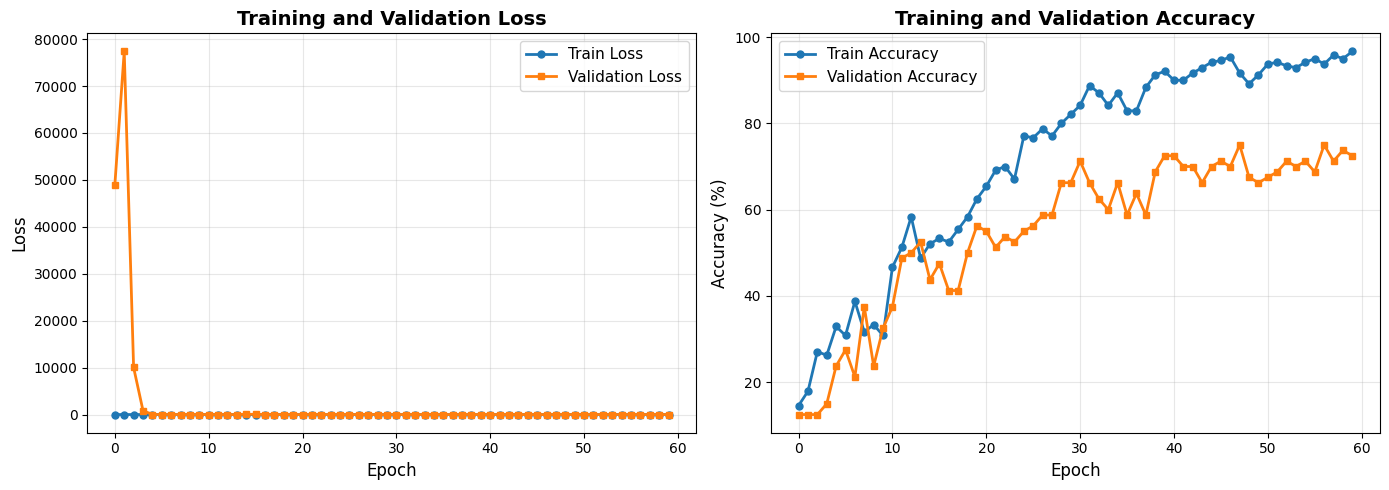


Training curves saved as 'training_curves.png'


In [47]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(train_losses, label='Train Loss', linewidth=2, marker='o', markersize=5)
axes[0].plot(val_losses, label='Validation Loss', linewidth=2, marker='s', markersize=5)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(train_accs, label='Train Accuracy', linewidth=2, marker='o', markersize=5)
axes[1].plot(val_accs, label='Validation Accuracy', linewidth=2, marker='s', markersize=5)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTraining curves saved as 'training_curves.png'")


In [48]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

model.eval()
all_preds = []
all_labels = []
test_loss = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate metrics
test_accuracy = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
avg_test_loss = test_loss / len(test_loader)
cm = confusion_matrix(all_labels, all_preds)

print("TEST SET PERFORMANCE METRICS")

print(f"Test Loss:     {avg_test_loss:.4f}")
print(f"Accuracy:      {test_accuracy * 100:.2f}%")
print(f"Precision:     {test_precision * 100:.2f}%")
print(f"Recall:        {test_recall * 100:.2f}%")
print(f"F1-Score:      {test_f1 * 100:.2f}%")


print(f"\nConfusion Matrix:\n{cm}\n")

# Save test results
torch.save({
    'test_loss': avg_test_loss,
    'accuracy': test_accuracy,
    'precision': test_precision,
    'recall': test_recall,
    'f1': test_f1,
    'confusion_matrix': cm
}, 'test_results.pth')

print("Test results saved as 'test_results.pth'")


print("TRAINING AND EVALUATION COMPLETE!")


TEST SET PERFORMANCE METRICS
Test Loss:     1.1258
Accuracy:      62.50%
Precision:     64.75%
Recall:        62.50%
F1-Score:      62.09%

Confusion Matrix:
[[10  0  0  0  0  0  0  0]
 [ 0  2  3  2  0  1  0  2]
 [ 0  1  6  0  0  0  0  3]
 [ 0  3  0  4  0  3  0  0]
 [ 0  0  0  0  8  0  0  2]
 [ 0  0  0  0  0  9  0  1]
 [ 0  0  0  1  0  1  6  2]
 [ 0  0  0  0  1  3  1  5]]

Test results saved as 'test_results.pth'
TRAINING AND EVALUATION COMPLETE!
